In [1]:
# -*- config : utf-8 -*-
# 라이브러리 import
import requests
import struct
import base64
import matplotlib.pyplot as plt

import numpy as np
import cv2

import tensorflow as tf

import time as ti
import warnings

# 경고 메시지 무시
warnings.filterwarnings(action='ignore')

In [2]:
# --- 분석 데이터 로딩 ---
# ElasticSearch에서 데이터 수신
start = ti.time()
r = requests.get(url = "https://quickstart-es-http.jmsohn-test:9200/es-short/_doc/47", verify=False)
end = ti.time()

print("elapsed : %f" %(end - start))

elapsed : 0.996530


In [3]:
# --- json 데이터 디코딩 ---
# base64 디코딩 후 short 데이터로 변경하기 위한 unpack iterator 생성
jsondata = r.json()
bindata = base64.b64decode(jsondata["_source"]["data"])
iterdata = struct.iter_unpack('<h', bindata)

In [4]:
# --- short 데이터 생성 ---
# 10000개만 테스트용으로 사용
noise = []
for index in range(10000):
    noise.append(next(iterdata)[0])

(48, 64, 3)


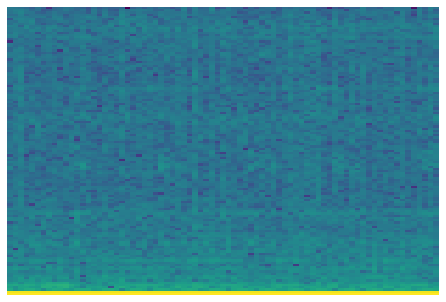

In [5]:
# --- 전처리 수행 ---
# 원본 데이터에서 Spectogram 이미지 생성
plt.specgram(noise, Fs=2000)
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
figure = plt.gcf()
figure.canvas.draw()

# 배열 형태로 전환 및 이미지 리사이즈
# 이미지를 numpy 배열로 변환
specImg = np.array(figure.canvas.renderer._renderer)

# 이미지를 48 * 64로 변환
specImg = cv2.resize(specImg, None, fx=64/432, fy=48/288)

# 오픈 cv는 이미지를 alpha값까지 총 4개의 값을 가짐
# 사용할 이미지는 alpha값을 제외한 값을 사용하도록 변환
specImg = specImg[:, :, 0:3]

# 0 ~ 1 사이의 값으로 변환하기 위해 256으로 나눔
# 사실 255(색상 범위 0 ~ 255)로 나누는 것이 맞으나, 인하공전 방식에 맞춤
specImg = specImg / 255

print(specImg.shape)

In [6]:
# --- 분석 모델로 분석 수행 및 결과 저장 클래스 선언 ---
class EsvibAnalyzer:
    def __init__(self, modeldir):
        self.modeldir = modeldir
        self.elapsedTime = 0
        self.predictList = []
    
    def analysis(self, inputList):
        with tf.Session(graph=tf.Graph()) as sess:
            print("START:" + self.modeldir)
            
            # 모델 로딩
            tf.saved_model.loader.load(sess, ["ver1"], self.modeldir)
            
            graph = tf.get_default_graph()
            x = graph.get_tensor_by_name("in:0")
            use_dropout = graph.get_tensor_by_name("use_dropout:0")
            out = graph.get_tensor_by_name("out:0")
            
            # 모델 분석 수행
            startTime = ti.time()
            _out = sess.run([out], feed_dict={x:inputList, use_dropout:False})
            endTime = ti.time()
            
            self.elapsedTime = endTime - startTime
            
            # 분석 결과 저장
            for index in range(0, inputList.shape[0]):
                self.predictList.append(np.argmax(_out[0][index], axis=0))
                
            print("END:" + self.modeldir)

In [7]:
# --- 분석 수행 및 결과 출력 ---
model = EsvibAnalyzer('/src/hyebin/model/SPEC-01')
model.analysis(np.array([specImg]))

print("elapsed time : %f" %model.elapsedTime)
print("predict:%d" %model.predictList[0])

START:/src/hyebin/model/SPEC-01
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


OSError: SavedModel file does not exist at: /src/hyebin/model/SPEC-01/{saved_model.pbtxt|saved_model.pb}